# 1. Dataset & Data exploration 

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import nltk
import spacy
import string
import re
import warnings

from nltk.corpus import stopwords
from nltk.collocations import *
from collections import Counter
from nltk.stem import porter
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('genesis')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
stemmer = porter.PorterStemmer()

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Importing the dataset

In [2]:
# Importing the dataset
url = 'https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/Digital_Music_5.json?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q'
df_raw = pd.read_json(url)
full_df = pd.DataFrame.from_records(df_raw['data'])


In [3]:
full_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


## exploration 

In [4]:
full_df['overall'].describe()

count    169781.000000
mean          4.700019
std           0.713420
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [5]:
#Number of reviews
print('- Number of reviews:', len(full_df))

#Number of different products reviewed
print('- Number of different products reviewed: ', len(full_df.asin.unique()))

#Number of people who reviewed
print('- Number of people who reviewed: ', len(full_df.reviewerID.unique()))

#Reviews range and average
print('- max rating: ', full_df.overall.max())
print('- min rating: ', full_df.overall.min())
print('- avg rating: ', full_df.overall.mean())

#Time range
start = pd.to_datetime(full_df['unixReviewTime'],unit='s').min().date()
end = pd.to_datetime(full_df['unixReviewTime'],unit='s').max().date()

print('- First review: ', start)
print('- Last review: ', end)


- Number of reviews: 169781
- Number of different products reviewed:  11797
- Number of people who reviewed:  16566
- max rating:  5.0
- min rating:  1.0
- avg rating:  4.700019436803883
- First review:  1998-07-09
- Last review:  2018-09-26


Distribution of rating

Text(0, 0.5, 'reiew counts')

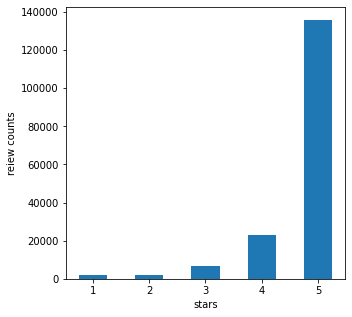

In [6]:
ax = full_df.overall.hist(grid=False, bins=np.arange(0.75,5.75,0.5),figsize=(5,5))

ax.set_xlabel("stars")
ax.set_ylabel("reiew counts")

Distribution of reviews per product

In [7]:
reviews_per_asin = full_df.asin.value_counts()
reviews_per_asin

B00CZF8B68    574
B00BWGHIHY    316
B00136J7ZE    294
B00EH49FRE    283
B00136NUG6    262
             ... 
B000W1S2WU      1
B00125MGQI      1
B001QET6G8      1
B001664ADA      1
B00138APMQ      1
Name: asin, Length: 11797, dtype: int64

reviews product-counts
5      2072
6      1506
7      1050
8       824
9       684
       ... 
146       1
147       1
148       1
152       1
574       1
Name: asin, Length: 163, dtype: int64


Text(0, 0.5, 'product counts')

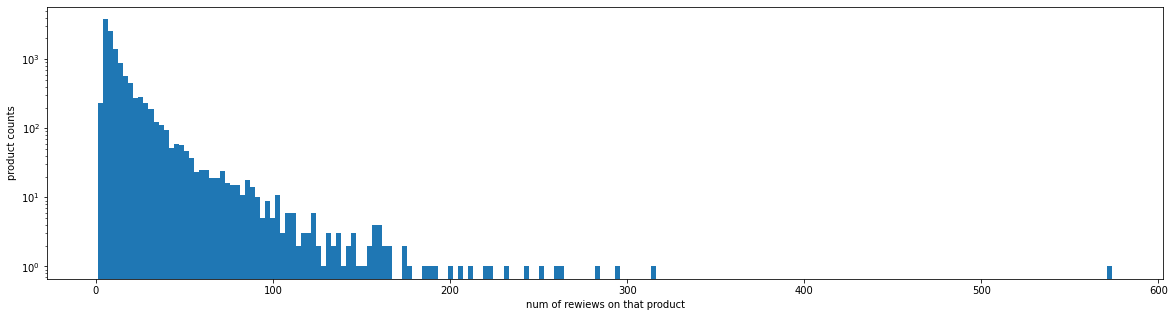

In [8]:
print("reviews product-counts")
print(reviews_per_asin.value_counts())

ax = reviews_per_asin.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews on that product")
ax.set_ylabel("product counts")

Distribution of reviews per user

In [9]:
reviews_per_user = full_df.reviewerID.value_counts()
reviews_per_user

A3W4D8XOGLWUN5    791
A2H3JURQZOHVMB    314
A36EDWL4F3AASU    223
A165P3MOJV3OVZ    219
AVKHYC2D7MD56     214
                 ... 
A2VWLNEBMW4ITQ      2
A2M4D98UYXMUZE      2
A518S7KT78N51       2
A25HR6FTWBQ2NZ      1
A70WPHE33U5B        1
Name: reviewerID, Length: 16566, dtype: int64

reviews user-counts
5      4559
6      2798
7      1927
8      1288
9       974
       ... 
101       1
102       1
314       1
106       1
791       1
Name: reviewerID, Length: 125, dtype: int64


Text(0, 0.5, 'user counts')

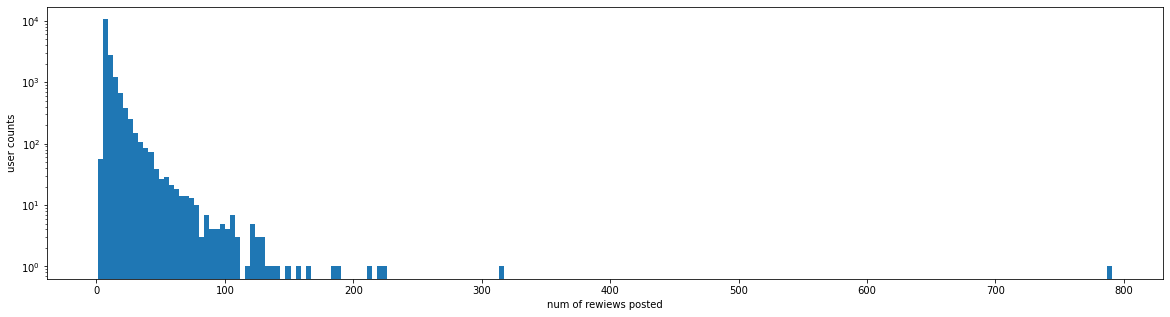

In [10]:
print("reviews user-counts")
print(reviews_per_user.value_counts())

ax = reviews_per_user.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews posted")
ax.set_ylabel("user counts")


# 2. Text basic pre-processing

## (Col:'Sentiment') based on the value of “rating of the product”:<br/> i. Ratings 4,5: Positive <br/>ii. Rating 3: Neutral <br/>iii. Ratings 1,2: Negative


In [11]:
full_df['Sentiment'] = np.where((full_df['overall'] > 3), 'Positive', 
                          np.where((full_df['overall'] < 3), 'Negative', 'Neutral'))
full_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Sentiment
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,Positive
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,Positive
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN,Positive
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN,Positive
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN,Positive


In [12]:
full_df['Sentiment'].value_counts() #how can we balance this data?

Positive    158985
Neutral       6792
Negative      4004
Name: Sentiment, dtype: int64

## columns selection

In [13]:
full_df['verified'].value_counts()

True     148944
False     20837
Name: verified, dtype: int64

In [14]:
#full_df.info()

In [15]:
cols = ['reviewText','summary']
full_df['NewReview'] = full_df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


In [16]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         169781 non-null  float64
 1   vote            7611 non-null    object 
 2   verified        169781 non-null  bool   
 3   reviewTime      169781 non-null  object 
 4   reviewerID      169781 non-null  object 
 5   asin            169781 non-null  object 
 6   style           157989 non-null  object 
 7   reviewerName    169776 non-null  object 
 8   reviewText      169623 non-null  object 
 9   summary         169745 non-null  object 
 10  unixReviewTime  169781 non-null  int64  
 11  image           182 non-null     object 
 12  Sentiment       169781 non-null  object 
 13  NewReview       169781 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 17.0+ MB


In [17]:
full_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Sentiment,NewReview
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,Positive,"This is awesome to listen to, A must-have for ..."
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,Positive,bien Five Stars


In [18]:
#reviewerID will be useful later to see if they are outliers or not
music_review_df = full_df.drop(columns=['vote','reviewerID','image','reviewTime','reviewerID','style','reviewerName','unixReviewTime','reviewText','summary'])

In [19]:
music_review_df.head(2)

,overall,verified,asin,Sentiment,NewReview
0,5.0,True,3426958910,Positive,"This is awesome to listen to, A must-have for ..."
1,5.0,True,3426958910,Positive,bien Five Stars


In [20]:
music_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   overall    169781 non-null  float64
 1   verified   169781 non-null  bool   
 2   asin       169781 non-null  object 
 3   Sentiment  169781 non-null  object 
 4   NewReview  169781 non-null  object 
dtypes: bool(1), float64(1), object(3)
memory usage: 5.3+ MB


## sampling 

In [22]:
n_samples = 1000 # @param {type:"integer"}

#Getting the reviews from the dataset
sample_df=music_review_df.sample(n = n_samples)
reviews = [str(review) for review in sample_df.NewReview.values]

#sample = reviews[:1000] #To reduce the runtime

In [23]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 138733 to 112119
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   overall    1000 non-null   float64
 1   verified   1000 non-null   bool   
 2   asin       1000 non-null   object 
 3   Sentiment  1000 non-null   object 
 4   NewReview  1000 non-null   object 
dtypes: bool(1), float64(1), object(3)
memory usage: 40.0+ KB


In [25]:

# average length
print('- average review length (words): ', len(re.findall(r'\w+', ' '.join(reviews)))/len(reviews))

- average review length (words):  32.113


In [24]:
sample_df.head()

,overall,verified,asin,Sentiment,NewReview
138733,5.0,True,B00137VQYS,Positive,In its day this song never really got a whole ...
123842,5.0,True,B000V691S0,Positive,Great song! Five Stars
94380,5.0,False,B00G7MJ4R0,Positive,This is one of my greatest value finds! I list...
8383,5.0,True,B000W1MDPW,Positive,This is the best CD/album on the market and Am...
88447,5.0,True,B00CO73XHY,Positive,"Wonderful song, utterly sad video though. Love..."


# 3. Text representation (approaches in course module 2)

## Tokenisation, Lemmatization, Stemming, pos, entities

In [26]:
#Tokenisation
tokens = [[token.text for token in nlp(sentence)] for sentence in reviews]

#Lemmatization
lemmas = [[token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in nlp(sentence)] for sentence in reviews]

#Stemming
stems = [[stemmer.stem(token) for token in sentence] for sentence in tokens]

#Getting pos
pos = [nltk.pos_tag(token) for token in tokens]

#Getting entities
entities = [[[ent.text, ent.label_] for ent in nlp(sentence).ents] for sentence in reviews] 

In [27]:
#Most common people
people = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='PERSON']]
print('5 most common people: ', Counter(people).most_common(10))

#Most common music
music = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='WORK_OF_ART']]
print('5 most common work of art: ', Counter(music).most_common(10))

5 most common people:  [('James', 12), ('Jesus', 7), ('James Taylor', 6), ('Mono', 5), ('Brahms', 5), ('Elvis', 4), ('Neptunes', 4), ('Cher', 4), ('Oscar', 4), ('Motown', 4)]
5 most common work of art:  [('Love', 12), ('Four Stars', 4), ('Believe', 3), ('Five Stars', 2), ('Living Proof', 2), ('My Favorite Things', 2), ('No Guts, No Glory', 2), ('O Holy Night', 2), ('Light My Fire', 1), ('The Sound Of Silence', 1)]


In [28]:
#Taking the stems or the lemmas 
ptext = [' '.join(word) for word in lemmas]

#Converting to lowercase
ptext = [review.lower() for review in ptext]

#Removing numbers
ptext = [re.sub(r'\d+', '', review) for review in ptext]

#Removing punctuation
ptext = [re.sub(r'[^\w\s]',' ',review) for review in ptext]
ptext = [re.sub(' +', ' ', review) for review in ptext]
ptext = [re.sub('_', '', review) for review in ptext]

#Removing leading and trailing whitespaces
ptext = [review.strip() for review in ptext]

#Removing stopwords
ptext = [' '.join([word for word in review.split() if word not in stop_words]) for review in ptext]

In [29]:
frame = {'Original': reviews, 
        'After Proprocessing': ptext}

pd.DataFrame.from_dict(frame)


,Original,After Proprocessing
0,In its day this song never really got a whole ...,day song never really get whole lot air play l...
1,Great song! Five Stars,great song five star
2,This is one of my greatest value finds! I list...,one great value find listen wonderful pleasant...
3,This is the best CD/album on the market and Am...,good cd album market amazon lee ann womack jew...
4,"Wonderful song, utterly sad video though. Love...",wonderful song utterly sad video though love s...
...,...,...
995,Awesome!! Five Stars,awesome five star
996,"Prime Cuts: Shout for Joy, Little Drummer Boy,...",prime cuts shout joy little drummer boy holy n...
997,One of my all time favorites. Love the fast b...,one time favorite love fast beat saxophone bri...
998,"Great riff in this one, never heard all my lif...",great riff one never hear life woman tokyo hus...


In [30]:
#Number of words
print('Number of words:')

bef = len(re.findall(r'\w+', ' '.join(reviews)))
aft = len(re.findall(r'\w+', ' '.join(ptext)))

print('- Before preprocessing: ', bef )
print('- After preprocessing: ', aft )
print()

#Average review length
print('Average review length:')

bef_a = bef/n_samples
aft_a = aft/n_samples

print('- Before preprocessing: ', bef_a )
print('- After preprocessing: ', aft_a )
print()

#Punctuation
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
punct_b = 0
for i in sample_df:
    punct_b += count(i,set(string.punctuation))
punct_a = 0
for i in ptext:
    punct_a += count(i,set(string.punctuation))
    
print('Number of punctuation character:')
print('- Before preprocessing: ', punct_b)
print('- After preprocessing: ', punct_a)
print()


Number of words:
- Before preprocessing:  32113
- After preprocessing:  16783

Average review length:
- Before preprocessing:  32.113
- After preprocessing:  16.783

Number of punctuation character:
- Before preprocessing:  0
- After preprocessing:  0



## glove

In [31]:
from keras.utils import get_file

dir1 = get_file(origin="https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/glove.6B.100d.zip.001?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q")
dir2 = get_file(origin="https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/glove.6B.100d.zip.002?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q")

dir1

'/root/.keras/datasets/glove.6B.100d.zip.001'

In [32]:
### for Colab!!! change path if not running in Colab 

!cat /root/.keras/datasets/glove.6B.100d.zip* > /root/.keras/datasets/glove.6B.100d.zip

!unzip -f /root/.keras/datasets/glove.6B.100d.zip 

Archive:  /root/.keras/datasets/glove.6B.100d.zip


In [33]:
EMBEDDING_DIM = 100 # @param {type:"integer"}

In [34]:

# first, build index mapping words in the embeddings set
# to their embedding vector

embeddings_index = {}
#C:\Courses_cent\COMP 262\practical-nlp-master\Ch4\Glove6B
#with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf-8") as f:
with open("glove.6B.100d.txt", encoding ="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))

def get_embeddings(word):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # words not found in embedding index will be all-zeros.
        embedding_vector = np.zeros(shape=(EMBEDDING_DIM, ))
    return embedding_vector

Found 400000 word vectors in Glove embeddings.


In [35]:
embeded = [[get_embeddings(word) for word in review.split() ] for review in ptext]


In [36]:
frame = {'Original': reviews, 
        'After embedding': embeded}

pd.DataFrame.from_dict(frame)


,Original,After embedding
0,In its day this song never really got a whole ...,"[[-0.36689, 0.4154, 0.13478, -0.17841, -0.4005..."
1,Great song! Five Stars,"[[-0.013786, 0.38216, 0.53236, 0.15261, -0.296..."
2,This is one of my greatest value finds! I list...,"[[-0.22557, 0.49418, 0.4861, -0.4332, 0.13738,..."
3,This is the best CD/album on the market and Am...,"[[-0.030769, 0.11993, 0.53909, -0.43696, -0.73..."
4,"Wonderful song, utterly sad video though. Love...","[[0.19742, 0.5114, 0.19043, -0.20615, -0.23031..."
...,...,...
995,Awesome!! Five Stars,"[[-0.18008, 0.084106, 0.72864, -0.77307, -0.60..."
996,"Prime Cuts: Shout for Joy, Little Drummer Boy,...","[[-1.6661, -0.62657, 0.5335, 1.0205, 0.099005,..."
997,One of my all time favorites. Love the fast b...,"[[-0.22557, 0.49418, 0.4861, -0.4332, 0.13738,..."
998,"Great riff in this one, never heard all my lif...","[[-0.013786, 0.38216, 0.53236, 0.15261, -0.296..."



# 4. Modeling 

## VADR sentiment

In [37]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [38]:
!pip install --upgrade vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
nltk.download('sentiwordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [41]:
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
    print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
 
    else :
        print("Neutral")

In [42]:
sample_df['NewReview']

138733    In its day this song never really got a whole ...
123842                               Great song! Five Stars
94380     This is one of my greatest value finds! I list...
8383      This is the best CD/album on the market and Am...
88447     Wonderful song, utterly sad video though. Love...
                                ...                        
21828                                  Awesome!! Five Stars
81602     Prime Cuts: Shout for Joy, Little Drummer Boy,...
53561     One of my all time favorites.  Love the fast b...
128759    Great riff in this one, never heard all my lif...
112119    It is exactly that, "Big Guitar Box"!!  I am e...
Name: NewReview, Length: 1000, dtype: object

In [43]:
sample_df.reset_index(inplace=True)

In [44]:
sentiment_scores(sample_df['NewReview'][0])


Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.935, 'pos': 0.065, 'compound': 0.6486}
sentence was rated as  0.0 % Negative
sentence was rated as  93.5 % Neutral
sentence was rated as  6.5 % Positive
Sentence Overall Rated As Positive


In [45]:
from nltk.corpus import sentiwordnet as swn
breakdown = swn.senti_synset('breakdown.n.03')

In [46]:
list(swn.senti_synsets('slow'))

[SentiSynset('decelerate.v.01'),
 SentiSynset('slow.v.02'),
 SentiSynset('slow.v.03'),
 SentiSynset('slow.a.01'),
 SentiSynset('slow.a.02'),
 SentiSynset('dense.s.04'),
 SentiSynset('slow.a.04'),
 SentiSynset('boring.s.01'),
 SentiSynset('dull.s.08'),
 SentiSynset('slowly.r.01'),
 SentiSynset('behind.r.03')]

## Text blob

In [47]:
from textblob import TextBlob

In [48]:
wiki = TextBlob(sample_df['NewReview'][0])

In [49]:
import nltk
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [50]:
#Parts of Speech
wiki.tags

[('In', 'IN'),
 ('its', 'PRP$'),
 ('day', 'NN'),
 ('this', 'DT'),
 ('song', 'NN'),
 ('never', 'RB'),
 ('really', 'RB'),
 ('got', 'VBD'),
 ('a', 'DT'),
 ('whole', 'JJ'),
 ('lot', 'NN'),
 ('of', 'IN'),
 ('air-play', 'NN'),
 ('on', 'IN'),
 ('my', 'PRP$'),
 ('local', 'JJ'),
 ('top', 'JJ'),
 ('40', 'CD'),
 ('Radio', 'NNP'),
 ('Stations', 'NNP'),
 ('in', 'IN'),
 ('fact', 'NN'),
 ('I', 'PRP'),
 ('almost', 'RB'),
 ('forgot', 'VBD'),
 ('about', 'IN'),
 ('it', 'PRP'),
 ('myself', 'PRP'),
 ('until', 'IN'),
 ('I', 'PRP'),
 ('heard', 'VBD'),
 ('it', 'PRP'),
 ('on', 'IN'),
 ('TV', 'NN'),
 ('recently', 'RB'),
 ('This', 'DT'),
 ('is', 'VBZ'),
 ('one', 'CD'),
 ('of', 'IN'),
 ('those', 'DT'),
 ('songs', 'NNS'),
 ('that', 'IN'),
 ('I', 'PRP'),
 ('decided', 'VBD'),
 ('to', 'TO'),
 ('add', 'VB'),
 ('to', 'TO'),
 ('my', 'PRP$'),
 ('large', 'JJ'),
 ('MP3', 'NNP'),
 ('collection', 'NN'),
 ('before', 'IN'),
 ('I', 'PRP'),
 ('forgot', 'VBP'),
 ('about', 'IN'),
 ('it', 'PRP'),
 ('To', 'TO'),
 ('sum', 'VB'),
 ('t

In [51]:
wiki.noun_phrases

WordList(['whole lot', 'stations', 'mp3', 'sum things', 'karla bonoff', 'karla bonoff', 'personally'])

In [52]:
wiki.sentiment

Sentiment(polarity=0.10178571428571428, subjectivity=0.2785714285714286)

In [53]:
wiki.words

WordList(['In', 'its', 'day', 'this', 'song', 'never', 'really', 'got', 'a', 'whole', 'lot', 'of', 'air-play', 'on', 'my', 'local', 'top', '40', 'Radio', 'Stations', 'in', 'fact', 'I', 'almost', 'forgot', 'about', 'it', 'myself', 'until', 'I', 'heard', 'it', 'on', 'TV', 'recently', 'This', 'is', 'one', 'of', 'those', 'songs', 'that', 'I', 'decided', 'to', 'add', 'to', 'my', 'large', 'MP3', 'collection', 'before', 'I', 'forgot', 'about', 'it', 'To', 'sum', 'things', 'up', 'I', 'would', 'not', 'say', 'that', 'I', 'am', 'a', 'real', 'big', 'Karla', 'Bonoff', 'fan', 'but', 'I', 'do', 'like', 'some', 'of', 'her', 'songs', 'and', 'this', 'song', 'just', 'happens', 'to', 'be', 'one', 'of', 'them', 'KARLA', 'BONOFF', 'PERSONALLY'])

In [54]:
df_textblob = sample_df

In [55]:
df_textblob['sentiment'] = sample_df['NewReview'].apply(lambda tweet: TextBlob(tweet).sentiment)

In [56]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

df_textblob['sentiment'] = sample_df['NewReview'].apply(sentiment_calc)

In [57]:
df_textblob

,index,overall,verified,asin,Sentiment,NewReview,sentiment
0,138733,5.0,True,B00137VQYS,Positive,In its day this song never really got a whole ...,"(0.10178571428571428, 0.2785714285714286)"
1,123842,5.0,True,B000V691S0,Positive,Great song! Five Stars,"(1.0, 0.75)"
2,94380,5.0,False,B00G7MJ4R0,Positive,This is one of my greatest value finds! I list...,"(0.6884722222222223, 0.9161111111111112)"
3,8383,5.0,True,B000W1MDPW,Positive,This is the best CD/album on the market and Am...,"(0.68, 0.27799999999999997)"
4,88447,5.0,True,B00CO73XHY,Positive,"Wonderful song, utterly sad video though. Love...","(0.125, 0.9)"
...,...,...,...,...,...,...,...
995,21828,5.0,True,B00137G8MS,Positive,Awesome!! Five Stars,"(1.0, 1.0)"
996,81602,5.0,False,B009IQ0BB0,Positive,"Prime Cuts: Shout for Joy, Little Drummer Boy,...","(0.2585921717171718, 0.44733003108003105)"
997,53561,5.0,True,B001BIKU32,Positive,One of my all time favorites. Love the fast b...,"(0.375, 0.4875)"
998,128759,5.0,True,B0011Z339S,Positive,"Great riff in this one, never heard all my lif...","(0.46666666666666673, 0.7166666666666667)"


## Word Cloud

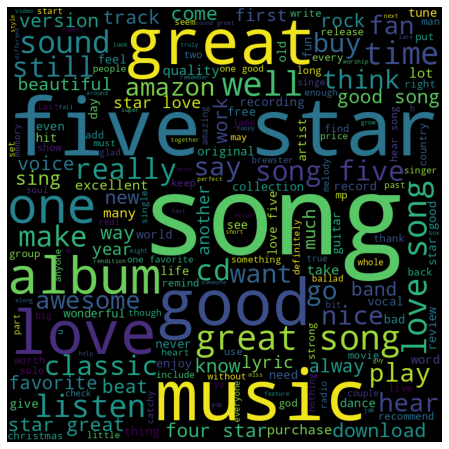

In [58]:
#Code take from GFG to generate Word Cloud

comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in ptext:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

#Generate word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
#Plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()